In [1]:
pip install numpy tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

2025-07-20 02:25:42.024617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 02:25:42.025033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 02:25:42.027804: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 02:25:42.035297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752958542.048187  215102 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752958542.05

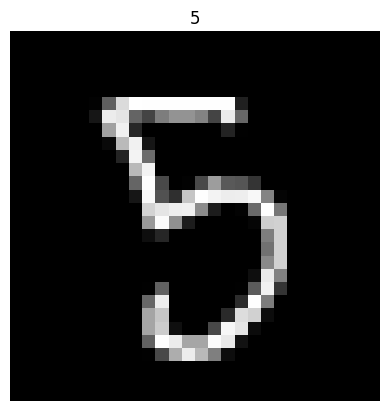

In [3]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

idx = np.random.randint(len(x_train))
img = x_train[idx]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(y_train[idx])
plt.show()

In [4]:
def build_generator(l_dim, class_nums):
    noise_input = layers.Input(shape=(l_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_oh = layers.Lambda(lambda x: tf.one_hot(tf.squeeze(x, axis=-1), depth=class_nums), output_shape=(class_nums,)) (label_input)
    combined_input = layers.Concatenate(axis = -1)([noise_input, label_oh])

    # (110,) -> (7, 7, 128)
    x = layers.Dense(units=7*7*128, activation='relu') (combined_input)
    x = layers.Reshape((7, 7, 128)) (x)

    # (7, 7, 128) -> (7, 7, 128)
    x = layers.Conv2D(128, kernel_size=2, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU()(x)

    # (7, 7, 128) -> (14, 14, 64)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU() (x)

    #  (14, 14, 64) -> (28, 28, 32)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU() (x)

    # (28, 28, 32) -> (28, 28, 1)
    x = layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='tanh') (x)

    model = Model([noise_input, label_input], x)

    return model

2025-07-20 02:25:46.286532: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-07-20 02:25:46.286576: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-20 02:25:46.286581: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: mskiehf
2025-07-20 02:25:46.286584: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: mskiehf
2025-07-20 02:25:46.286729: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-07-20 02:25:46.286742: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 570.133.7
2025-

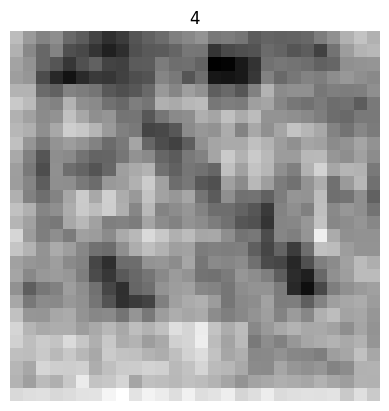

In [5]:
gen = build_generator(100, 10)

label = np.random.randint(0, 10, (1, 1))
noise = np.random.uniform(-1,1, (1, 100))
img = gen([noise, label], trainable=False)

img = 0.5*img + 0.5
plt.imshow(img[0,:,:,0], cmap='gray')
plt.title(label=label[0][0])
plt.axis('off')
plt.show()

In [6]:
def build_discriminator(input_dim):
    img_input = layers.Input(shape=input_dim)

    # (28, 28, 1) -> (14, 14, 32)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same') (img_input)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    # (14, 14, 32) -> (7, 7, 64)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same') (x)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    # (7, 7, 64) -> (3, 3, 128)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=2, padding='same') (x)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    x = layers.Flatten() (x)

    validity = layers.Dense(1, activation='sigmoid') (x)
    label = layers.Dense(10, activation='softmax') (x)

    model = Model(img_input, [validity, label])

    return model

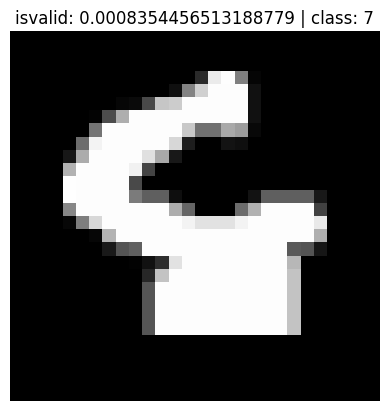

In [7]:
disc = build_discriminator((28,28,1))
idx = np.random.randint(len(x_train))
img = x_train[idx]
img = np.expand_dims(img, axis=0)

validity, label_prob = disc(img, trainable=False)
label = np.argmax(label_prob[0])

plt.imshow(img[0], cmap='gray')
plt.axis('off')
plt.title(f"isvalid: {validity[0][0]} | class: {label}")
plt.show()

In [8]:
latent_dim = 100
class_nums = 10
img_dim = (28, 28, 1)

In [9]:
def build_model(latent_dim = latent_dim, class_nums = class_nums, img_dim = img_dim):
    Gen = build_generator(latent_dim, class_nums)
    Disc = build_discriminator(img_dim)

    Disc.trainable = False

    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    image_input = Gen([noise_input, label_input])
    val, label_prob = Disc(image_input)

    combined = Model([noise_input, label_input], [val, label_prob])

    combined.compile(
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5),
        metrics = ['accuracy', 'accuracy']
    )

    Disc.trainable = True
    Disc.compile(
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
        loss_weights=[1, 1],
        optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        metrics = ['accuracy', 'accuracy']
    )

    return Gen, Disc, combined

In [10]:
Gen, Disc, comb_model = build_model()

In [11]:
def train_model(epochs, x_train, y_train, Gen = Gen, Disc = Disc, comb_model=comb_model, latent_dim = latent_dim, class_nums = class_nums, img_dim = img_dim, batch=64):
    
    x_train = (x_train - 127.5)/127.5

    for epoch in range(epochs):
        real_batch_label = np.ones((batch, 1))*np.random.uniform(0.9,1)
        fake_batch_label = np.ones((batch, 1))*np.random.uniform(0, 0.1)

        noise = np.random.uniform(-1, 1, (batch, latent_dim))
        fake_class = np.random.randint(0, 10, (batch, 1))
        fake_imgs = Gen.predict([noise, fake_class], verbose=0)

        idx = np.random.randint(0, len(x_train), batch)
        real_imgs = x_train[idx]
        real_class = y_train[idx]

        Disc.trainable = True
        disc_lossforreal = Disc.train_on_batch(real_imgs, [real_batch_label, real_class])
        disc_lossforfake = Disc.train_on_batch(fake_imgs, [fake_batch_label, fake_class])
        disc_loss = (disc_lossforfake[0] + disc_lossforreal[0])*0.5

        noise = np.random.uniform(-1, 1, (batch, latent_dim))
        fake_class = np.random.randint(0, 10, (batch, 1))

        Disc.trainable=False
        comb_loss = comb_model.train_on_batch([noise, fake_class], [real_batch_label, fake_class])

        if(epoch % 50 == 0):
            print(f"{epoch}/{epochs} | d_loss = {disc_loss} | comb_loss = {comb_loss[0]}")
        if(epoch%100 == 0):
            noise = np.random.uniform(-1, 1, (class_nums, latent_dim))
            labels = np.arange(0, class_nums).reshape(-1, 1)
            imgs = Gen.predict([noise, labels], verbose=0)

            imgs = (imgs+1)*0.5
            # imgs = 1-imgs -------to get background as white instead of black
            c= 5
            r = class_nums//c

            fig, axs = plt.subplots(r, c, figsize=(10, 4))

            for i in range(r):
                for j in range(c):
                    axs[i][j].imshow(imgs[i*c+j,:,:,0], cmap='gray')
                    axs[i][j].set_title(labels[i*c+j][0])
                    axs[i][j].axis('off')
            
            fig.suptitle(f"@epoch {epoch}")
            plt.tight_layout()
            plt.show()


E0000 00:00:1752958548.141243  215102 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/functional_3_1/leaky_re_lu_3_1/LeakyRelu/LeakyReluGrad' exist for missing node 'functional_3_1/conv2d_11_1/BiasAdd'.


0/1000 | d_loss = 2.943103551864624 | comb_loss = 2.9294652938842773


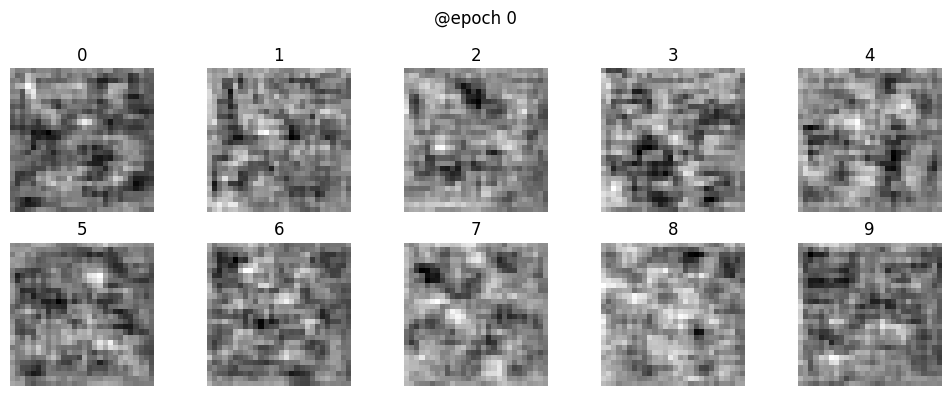

50/1000 | d_loss = 2.6162760257720947 | comb_loss = 2.509843349456787
100/1000 | d_loss = 2.1023900508880615 | comb_loss = 1.647855520248413


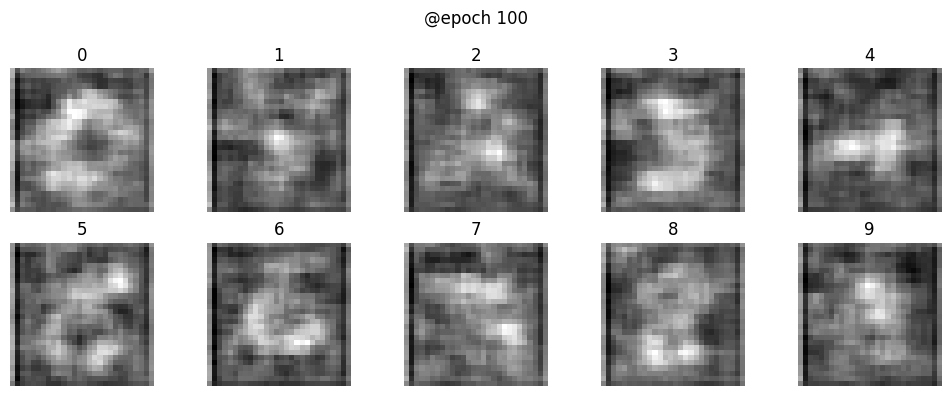

150/1000 | d_loss = 1.7615426778793335 | comb_loss = 1.2090810537338257
200/1000 | d_loss = 1.5439996719360352 | comb_loss = 0.9691925048828125


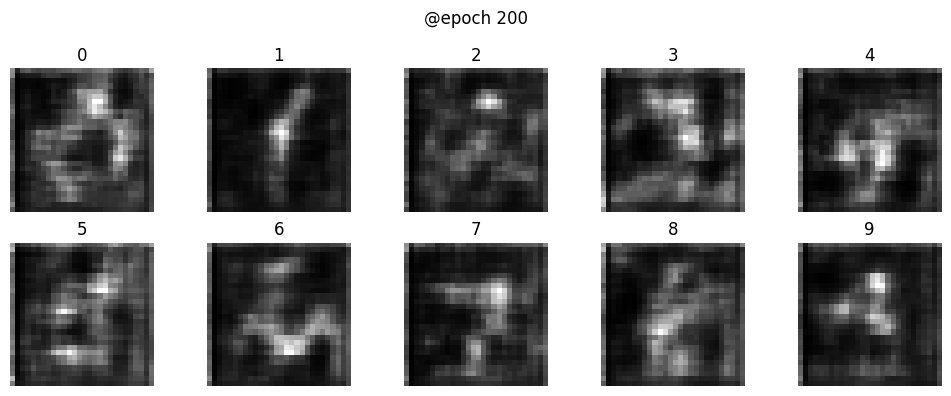

250/1000 | d_loss = 1.386194109916687 | comb_loss = 0.830076277256012
300/1000 | d_loss = 1.2675409317016602 | comb_loss = 0.730648934841156


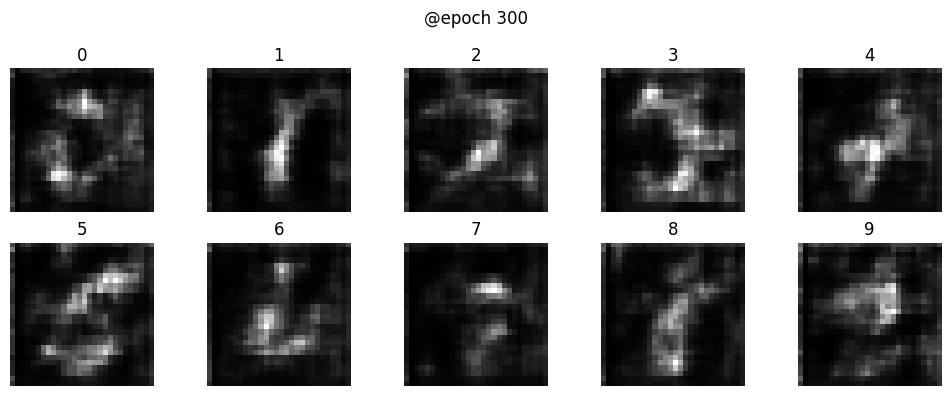

350/1000 | d_loss = 1.1750210523605347 | comb_loss = 0.6611053943634033
400/1000 | d_loss = 1.1158342361450195 | comb_loss = 0.609650731086731


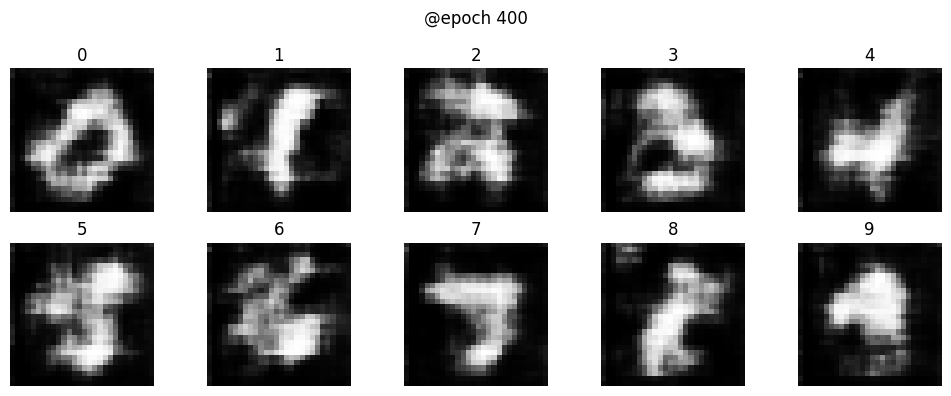

450/1000 | d_loss = 1.113930344581604 | comb_loss = 0.6180669665336609
500/1000 | d_loss = 1.1039804220199585 | comb_loss = 0.6296724081039429


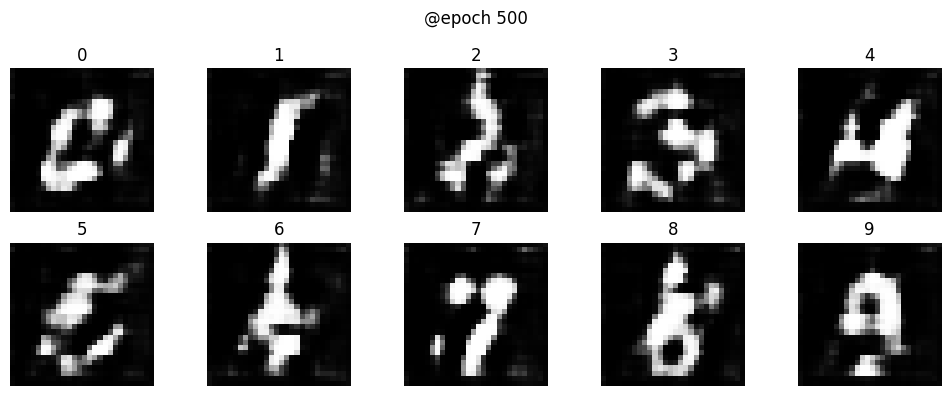

550/1000 | d_loss = 1.0956776142120361 | comb_loss = 0.6418616771697998
600/1000 | d_loss = 1.0866179466247559 | comb_loss = 0.6551160216331482


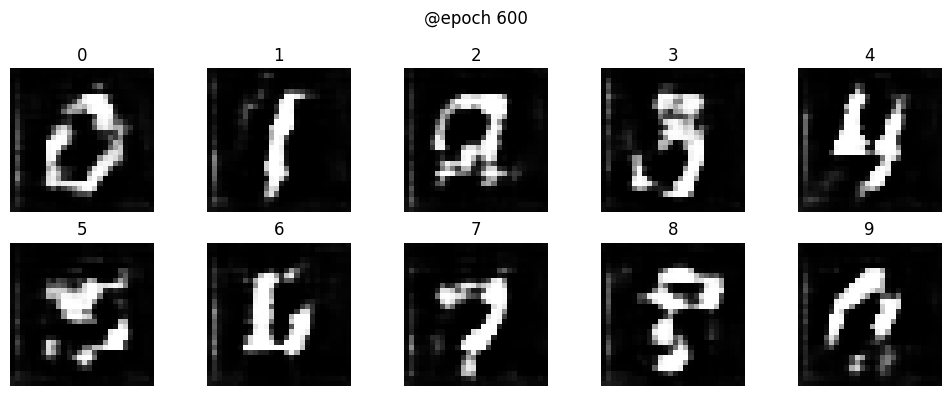

650/1000 | d_loss = 1.0762324333190918 | comb_loss = 0.6647960543632507
700/1000 | d_loss = 1.06662917137146 | comb_loss = 0.6718405485153198


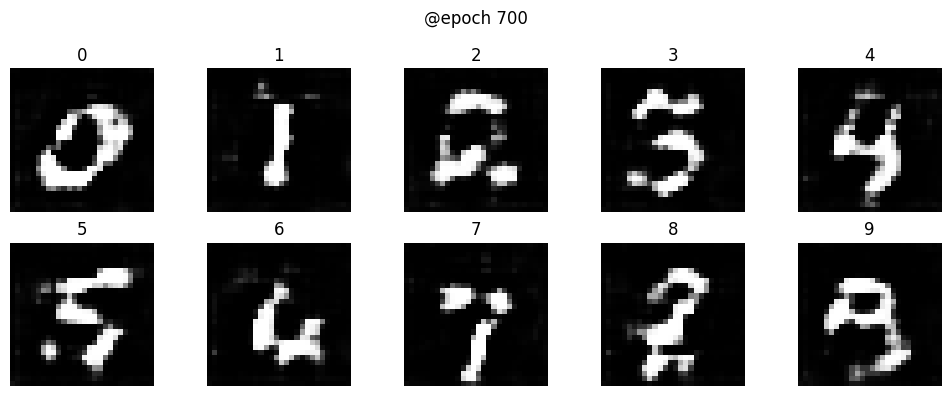

750/1000 | d_loss = 1.0584206581115723 | comb_loss = 0.6779727339744568
800/1000 | d_loss = 1.04990816116333 | comb_loss = 0.6837742924690247


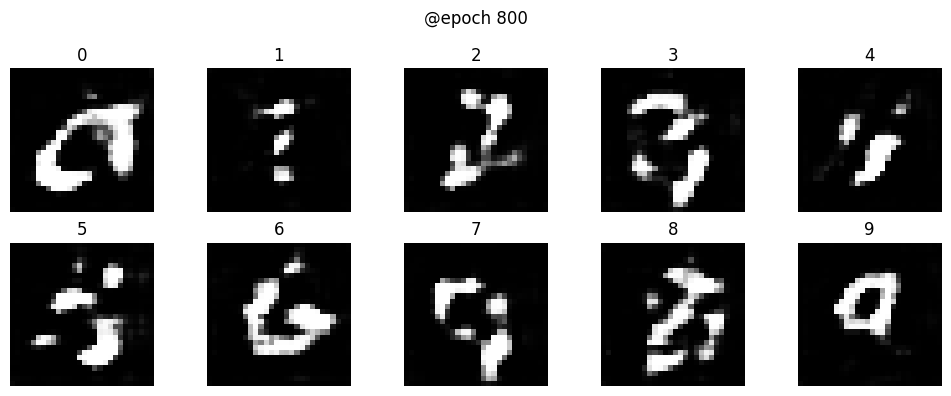

850/1000 | d_loss = 1.0429236888885498 | comb_loss = 0.6890772581100464
900/1000 | d_loss = 1.0355743169784546 | comb_loss = 0.6935123801231384


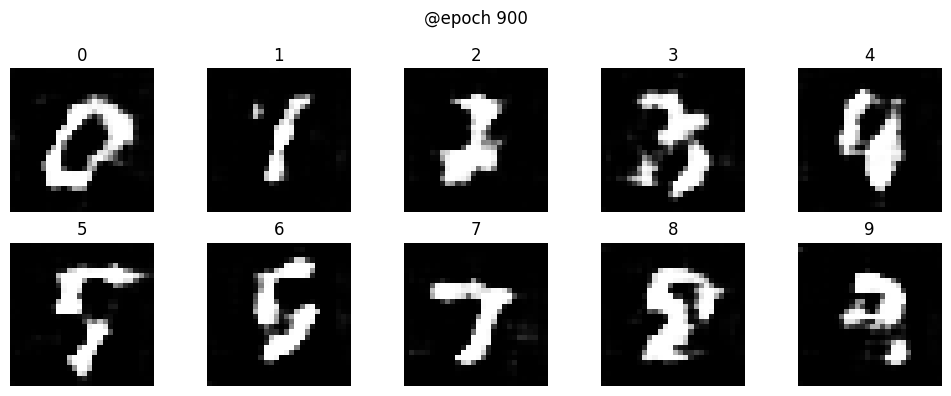

950/1000 | d_loss = 1.028611660003662 | comb_loss = 0.6976643204689026


In [12]:
train_model(1000, x_train, y_train)